## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## Compute the camera calibration matrix and distortion coefficients

## Import Necessary Modules

In [143]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Compute the camera calibration matrix and distortion coefficients

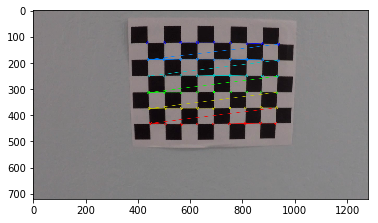

In [144]:
images = glob.glob('../camera_cal/calibration*.jpg')

# Make a list of calibration images

#zero 함수를 이용해서
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    #ret에는 성공 유무(True/False), corners에는 코너의 좌표
    # If found, draw corners

    if ret == True:
        # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        plt.imshow(img)
        
        
        
        

## Apply a distortion correction(Test)

In [145]:
#define function undistorting picture
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist,None, mtx)
    return dst

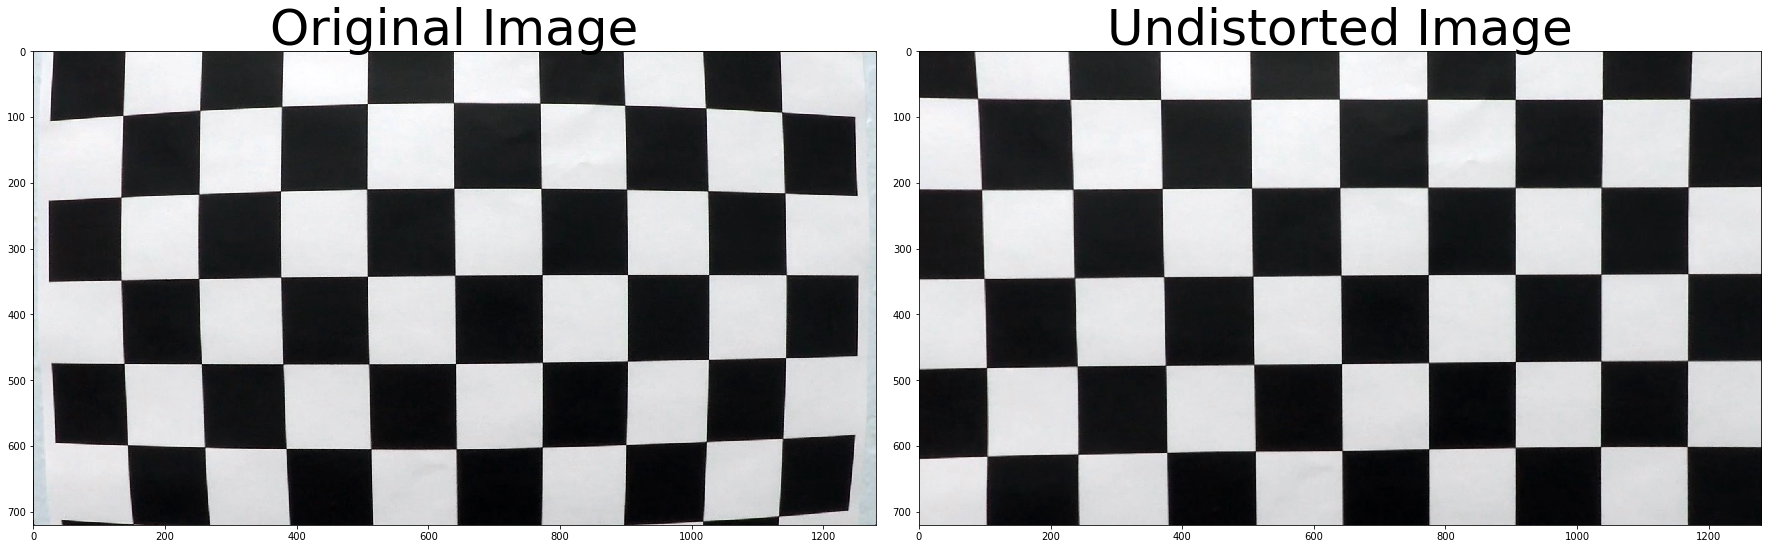

In [146]:
img = cv2.imread('../camera_cal/calibration1.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded binary image

## (1) color transforms and gradients

In [147]:
def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Applies a Gaussian Noise kernel"""
    blur=cv2.GaussianBlur(img, (5, 5), 0)
    
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(blur, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary),s_binary,sxbinary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

## (2) Applies an image mask

In [148]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    vertices = np.array([[(170,imshape[0]),(imshape[1]/2 - 80, 470), 
                          (imshape[1]/2 + 80, 450), (imshape[1] - 100,imshape[0])]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        #print(ignore_mask_color)
    else:
        ignore_mask_color = 255
        
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

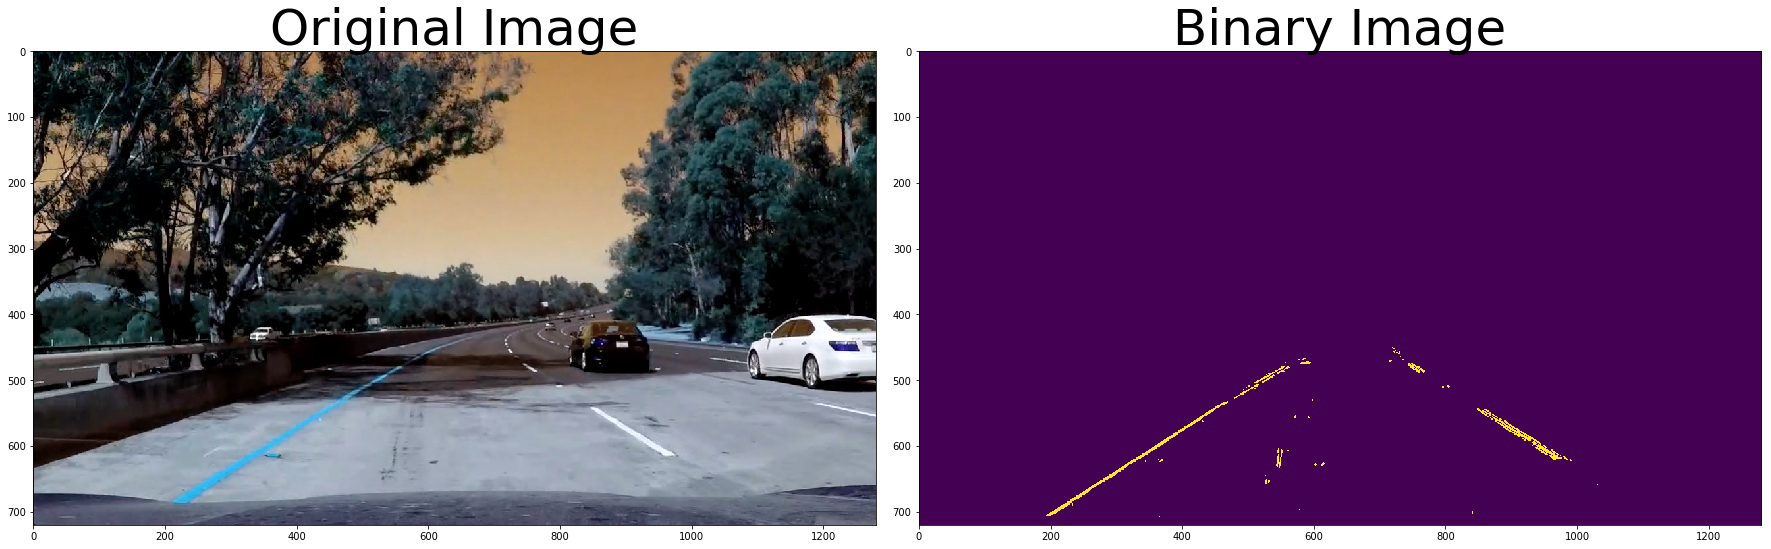

In [149]:
img=cv2.imread('../test_images/test5.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
binary_img= binary(undistorted, s_thresh=(170, 255), sx_thresh=(30, 100))
imshape = img.shape
masked_img=region_of_interest(binary_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(masked_img)
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform(Histogram)

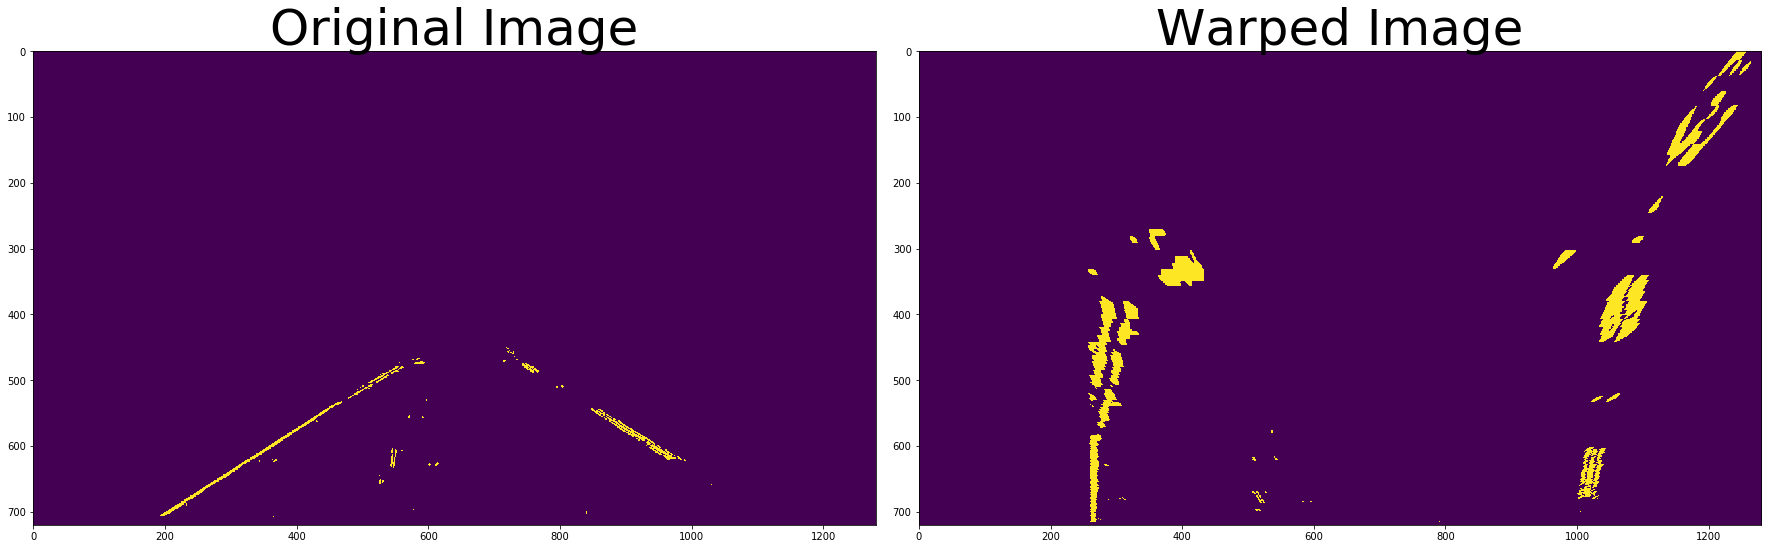

In [150]:
def Perspective_transform(img):

    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[685  ,451 ],[1100, 720],[ 220 , 720 ],[ 595 , 451]])
    offset = 300
    #dstr = np.float32([ [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset],[offset, offset]])
    #dst = np.float32([[1100  ,0 ],[1100 , 720],[ 220 , 720 ],[ 220 , 0]])
    dstr = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],[offset, img_size[1]],[offset, 0]])
    M = cv2.getPerspectiveTransform(src, dstr)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
warped = Perspective_transform(masked_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(masked_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Histogram (option)

In [151]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger value
    return np.sum(img[img.shape[0]//2:,:], axis=0)
#x축에 존재하는 모든 픽셀을 눌러주는 함수.

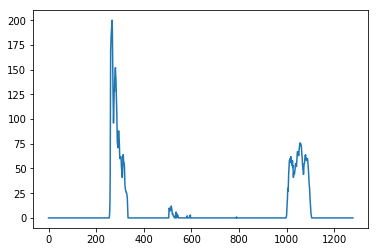

In [152]:
# Create histogram of image binary activations
histogram = hist(warped)
# Visualize the resulting histogram
plt.plot(histogram)

## Detect lane pixels and fit to find the lane boundary.

In [178]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
				# window 변수에서 높이 조절
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
				#currnet와 margin 이용해서, 좌우 위치 조절
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
       
        
        # Identify the nonzero pixels in x and y within the window #
				# 사각형 내부에 있는 흰 pixel
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # nonzero()뒤에 [0] 가 무슨 의미인지 알기 ㅁ

        # Append these indices to the lists
				#각각의 window 내에 있는 pixel의 index들을 left와 right 각각 하나의 리스트에 추가  
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
				#윈도우 내부의 픽셀의 수가 minpix 이상이 되면 current의 위치를 변경*******
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
		# 앞에서, 각 윈도우를 돌면서 만들어진 lane_inds를 연결해줌.
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
		# nonzero는 모든 흰색 픽셀들의 position을 담아준 리스트
		# nonezerox와 nonzeroy는 position의 x y 값을 구분
		# lane_inds들은 윈도우를 돌면서 각각의 윈도우에 존재하는 라인의 인덱스를 담은 리스트
		# 순서도 고려되어 있음.
		# 리스트들을(position과 index) 융합해서, 왼쪽차선과 오른쪽 차선의 position을 구분한
		# 네개의 리스트를 도출
		
    global leftx
    global lefty
    global rightx
    global righty
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial_viz(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    global left_fit_cr
    global right_fit_cr
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    global window_sliding 
    window_sliding = True

    return  left_fit,right_fit, out_img
def fit_polynomial(binary_warped):
    global leftx
    global lefty
    global rightx
    global righty
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
   
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    global left_fit_cr
    global right_fit_cr
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    
    global window_sliding 
    window_sliding = True

    return left_fit_cr,right_fit_cr

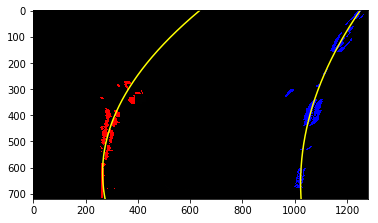

In [175]:
left_fit,right_fit, out_img = fit_polynomial_viz(warped)
#print(left_fit)

plt.imshow(out_img)

In [177]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
		#좌,우 차선 position의 x,y 값을 받아서 계수를 만들어 줌.
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
		# 대입 할 y (ploty)와 계수들을 가지고 polynomial을 그려줌
    global ploty
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    return left_fitx, right_fitx, ploty,left_fit_cr, right_fit_cr

def search_around_poly_viz(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    global leftx
    global lefty
    global rightx
    global righty
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
########################################################################################
    #선 기준 마진을 만들어서 양쪽 범위 생성
		#left_fit과 right_fit은 frame마다 fit_poly 함수를 지날 때 업데이트 되는 값.
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   

    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit_cr, right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
########################################################################################    
    ####부분의 순환을 이해하는 것이 중요 결과-> polynomial의 변화

		## Visualization ## ##important
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
		#np.zeros가 검정색(0)으로만 구성된 반면 out_img는 색을 입힐 수 있는 여지가 있는
		#검은 화면을 만드는 것.[0] vs [0,0,0]을 생각하면 이해 가능
    window_img = np.zeros_like(out_img)
		#왼쪽과 오른쪽 차선을 다른 색으로 색칠 해줌
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
# 선의 -margin부분과 +margin 부분으로 구성된 영역을 찾고 그 안에 있는 점들(line_pts)을 수집
# 수집한 점들을 앞서 만든 검은 배경(window_img)에 green 으로 색칠
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# 색칠한 window_img와 색칠한 레인 이미지를 합한다.
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

def search_around_poly(binary_warped):
    global leftx
    global lefty
    global rightx
    global righty
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    
    if ((len(leftx) == 0) or (len(rightx) == 0) or (len(righty) == 0) or (len(lefty) == 0)):
        left_fit,right_fit, frame= fit_polynomial(frame)
        return left_fit,right_fit, frame
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
########################################################################################
    #선 기준 마진을 만들어서 양쪽 범위 생성
		#left_fit과 right_fit은 frame마다 fit_poly 함수를 지날 때 업데이트 되는 값.
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit_cr, right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
########################################################################################    
    ####부분의 순환을 이해하는 것이 중요 결과-> polynomial의 변화

    
    return left_fit_cr, right_fit_cr

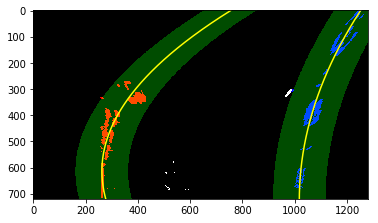

In [156]:
result= search_around_poly_viz(warped)

# View your output
plt.imshow(result)

## Detect lane pixels and fit to find the lane boundary.

In [157]:
def measure_curvature_pixels(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
  
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    # Calculation of R_curve (radius of curvature)
    left_curverad = np.power((1+np.square(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])),(3/2))/abs(2*left_fit_cr[0])
    right_curverad = np.power((1+np.square(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])),(3/2))/abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [158]:
# Calculate the radius of curvature in pixels for both lane lines
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit_cr, right_fit_cr)

print(left_curverad,'m', right_curverad,'m')

170.561068973 m 315.391395946 m


## Warp the detected lane boundaries back onto the original image.

In [159]:
def Inverse_Perspective_transform(img):

    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[685  ,451 ],[1100, 720],[ 220 , 720 ],[ 595 , 451]])
    offset = 300
    #dstr = np.float32([ [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset],[offset, offset]])
    #dst = np.float32([[1100  ,0 ],[1100 , 720],[ 220 , 720 ],[ 220 , 0]])
    dstr = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],[offset, img_size[1]],[offset, 0]])
    M = cv2.getPerspectiveTransform(dstr, src)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
#inversed = Inverse_Perspective_transform(result)

#plt.imshow(inversed)
#frame = cv2.addWeighted(inversed, 0.3, undistorted, 0.7, 0)
#plt.imshow(frame)

## Drawing

In [160]:
 def draw(img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
   
    result = Inverse_Perspective_transform(color_warp)
    frame = cv2.addWeighted(result, 0.3, img, 0.7, 0)
    return frame

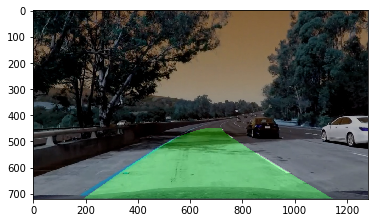

In [161]:
drawn=draw(undistorted)
plt.imshow(drawn)

## Pipeline

In [179]:
def pipeline(img):
    global window_sliding 
    original = cal_undistort(img, objpoints, imgpoints)
    
    #Compute the camera calibration matrix and distortion coefficients before 
    
    frame = binary(original, s_thresh=(170, 255), sx_thresh=(30, 100))
    frame=region_of_interest(frame)
    frame=Perspective_transform(frame)
    if window_sliding == False:
        left_fit_cr, right_fit_cr= fit_polynomial(frame)
    else:
        left_fit_cr, right_fit_cr=search_around_poly(frame)
    left_curverad, right_curverad=measure_curvature_pixels(ploty, left_fit_cr, right_fit_cr)
    curvature = (left_curverad + right_curverad) / 2
    car_pos = img.shape[1] / 2
    center = (abs(car_pos - curvature)*(3.7/650))/10
    curvature = 'Radius of Curvature: ' + str(round(curvature, 2)) + 'm'
    center = str(round(center, 3)) + 'm away from center'
    drawn=draw(original)
    frame = cv2.putText(drawn, curvature, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    frame = cv2.putText(frame, center, (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
   
        
    return frame

## MAIN

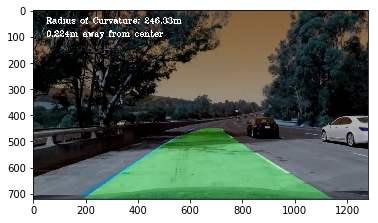

In [180]:
global window_sliding 
window_sliding == False

result=pipeline(img)
plt.imshow(result)




In [181]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [184]:
white_output = '../test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ../test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video ../test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 1260/1261 [22:55<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/solidWhiteRight.mp4 

CPU times: user 20min 30s, sys: 19.1 s, total: 20min 50s
Wall time: 22min 58s


In [185]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))